# Spring 2021 Lidar Data
S. Filhol, July 2021


-------
Part 1:  Find out when to convert bin file into DEMs

1. get wind, temperature, flux, precip and snow depth from flux station
2. identify events: precip, wind, transport.
3. create list of timestamp to convert bin to netcdf. High temporal resolution during events, low temporal resolution in low activity

-------
Part 2

1. write code to load files metadata to sort which file to process and post process
2. 

In [1]:
from wsn_client import query
from wsn_client import var_dict

import xarray as xr
import glob, getpass
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

## 1. Download data from database

In [2]:

start = datetime.datetime(2021,3,5,9)
end = datetime.datetime(2021,6,13,6)

var_oi_mean = ['FC1DRIFTmean_99_99_1_1_1',
          'FC2DRIFTmean_99_99_1_1_1',
          'WD_20_35_1_1_1',
          'WS_16_33_1_1_1',
          'TA_2_1_1_1_1',
          'METNOR_99_99_1_1_1',
          'METNOS_99_99_1_1_1']
var_oi_max = ['FC1DRIFTmax_99_99_1_1_1',
          'FC2DRIFTmax_99_99_1_1_1',
          'WD_20_35_1_1_1',
          'WS_16_33_1_1_1',
          'TA_2_1_1_1_1',
          'METNOR_99_99_1_1_1',
          'METNOS_99_99_1_1_1']

df_mean = query.query('clickhouse', serial=3668, table='finseflux_Biomet',limit=10000000,
                 fields=var_oi_mean, time__gte=start, time_lte=end,
                interval=60*12, interval_agg='mean')
df_max = query.query('clickhouse', serial=3668, table='finseflux_Biomet',limit=10000000,
                 fields=var_oi_max, time__gte=start, time_lte=end,
                interval=60*12, interval_agg='max')

In [3]:
df_mean.columns = [var_dict.CR6_biomet_perm[x] for x in df_mean.columns]
df_max.columns = [var_dict.CR6_biomet_perm[x] for x in df_max.columns]
df_mean.head()

,time,fc1drift_mean,fc2drift_mean,wd,ws,ta,metno_r,metno_s
time,,,,,,,,
2021-03-05 08:00:00,1614931200,0.001264,3.445,292.000000,6.552083,-8.786307,441.019017,NaN
2021-03-05 08:12:00,1614931920,0.001000,3.445,302.125000,6.151528,-8.698062,441.051119,NaN
2021-03-05 08:24:00,1614932640,0.001236,3.445,300.833333,6.182222,-8.708543,441.005372,NaN
2021-03-05 08:36:00,1614933360,0.002389,3.445,291.222222,7.727778,-8.812215,441.015701,NaN
2021-03-05 08:48:00,1614934080,0.001139,3.445,299.000000,6.308889,-8.492724,441.016264,NaN


In [4]:
# Correct data 
# 1. remove precipitation bucket signal
df_max['precip'] = df_max.metno_r.diff()
df_max.precip.loc[df_max.precip<-100] = 0

# 1. remove precipitation bucket signal
df_mean['precip'] = df_mean.metno_r.diff()
df_mean.precip.loc[df_mean.precip<-100] = 0

# 2. remove bad flowcapt 2 data (flowcapt sensor 2 keeps failing, and flowcapt 1 failing for some time)

# 3. remove negative snowdepth and 
df_max.metno_s.loc[df_max.metno_s<0] = np.nan
df_max.metno_s.loc[df_max.metno_s>100] = np.nan

def wswd_2_uv(df, ws='WS_16_33_1_1_1', wd='WD_20_35_1_1_1'):
    """
    Function to convert wind speed and direction to UV component

    :param df: [description], [type]
    :param ws: [description], defaults to 'WS_16_33_1_1_1',  str, optional
    :param wd: [description], defaults to 'WD_20_35_1_1_1',  str, optional
    :return: [description], [type]
    """    
    df[wd].loc[df[wd]<0] = df[wd].loc[df[wd]<0] + 360
    df['U'] = df[ws] * np.cos(270-df[wd]*np.pi/180)
    df['V'] = df[ws] * np.sin(270-df[wd]*np.pi/180)
    return df

# 4. convert ws, wd to U, V
df_mean = wswd_2_uv(df_mean, ws='ws', wd='wd')


/home/simonfi/miniconda3/envs/dataAna/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/simonfi/miniconda3/envs/dataAna/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/simonfi/miniconda3/envs/dataAna/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

## 2. Plot and Identification of events

In [5]:
# loading timestamp for which we have scans
dir_netcdf = '/media/' + getpass.getuser() + '/My Book/SO_spring_2021_processing/netcdf/'
netlist = glob.glob(dir_netcdf+'*.nc')
netlist.sort()

In [6]:
ds = xr.open_dataset(netlist[0]).time.to_dataframe()
ds['fname'] = netlist[0]
for file in netlist[1:]:
    ds2 = xr.open_dataset(file)
    df = ds2.time.to_dataframe()
    df['fname'] = file
    ds = ds.append(df)
    
    


In [7]:
ds

,time,fname
time,,
2021-03-11 21:12:00,2021-03-11 21:12:00,/media/simonfi/My Book/SO_spring_2021_processi...
2021-03-11 21:24:00,2021-03-11 21:24:00,/media/simonfi/My Book/SO_spring_2021_processi...
2021-03-11 21:36:00,2021-03-11 21:36:00,/media/simonfi/My Book/SO_spring_2021_processi...
2021-03-11 21:48:00,2021-03-11 21:48:00,/media/simonfi/My Book/SO_spring_2021_processi...
2021-03-11 22:00:00,2021-03-11 22:00:00,/media/simonfi/My Book/SO_spring_2021_processi...
...,...,...
2021-04-23 22:36:00,2021-04-23 22:36:00,/media/simonfi/My Book/SO_spring_2021_processi...
2021-04-23 22:48:00,2021-04-23 22:48:00,/media/simonfi/My Book/SO_spring_2021_processi...
2021-04-23 23:00:00,2021-04-23 23:00:00,/media/simonfi/My Book/SO_spring_2021_processi...


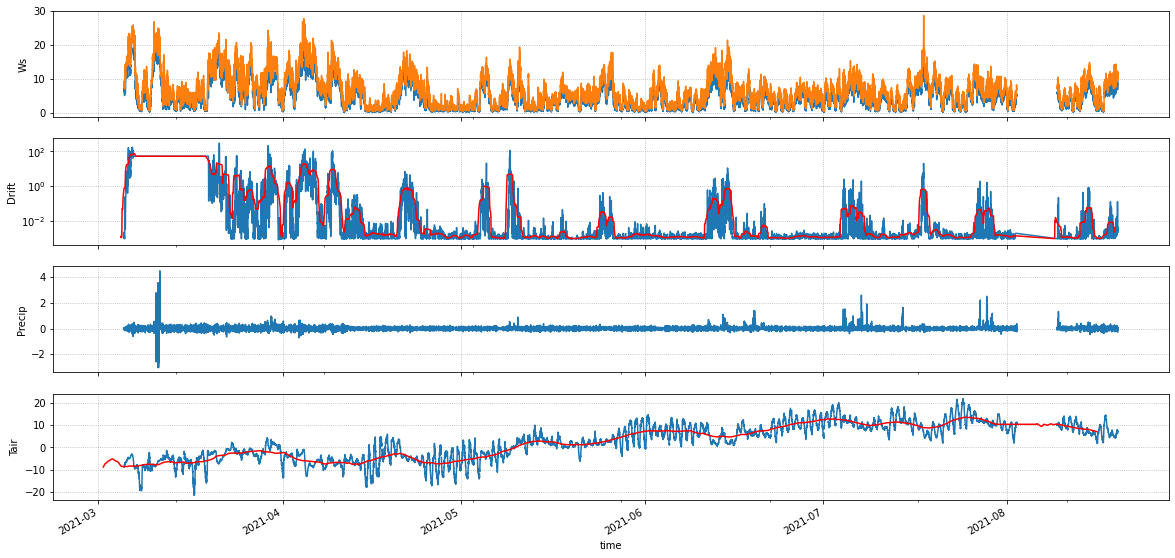

In [8]:
fig, ax = plt.subplots(4,1,sharex=True, figsize=(20,10))

# wind speed panel
df_mean.ws.plot(ax=ax[0], label='Mean')
df_max.ws.plot(ax=ax[0], label='Max')
#ax[0].vlines(ds.time, 0, 30)
ax[0].set_ylabel('Ws')


# flowcapt panel
#(df_mean.fc1drift_mean).plot(ax=ax[1])
ax[1].semilogy(df_mean.fc1drift_mean)
ax[1].semilogy(df_mean.fc1drift_mean.rolling('1D').mean().shift(-12, freq='h'), color='r')
ax[1].set_ylabel('Drift')


# Precipitation panel
df_max.precip.plot(ax=ax[2])
ax[2].set_ylabel('Precip')
# Temperature 
df_mean.ta.plot(ax=ax[3])
df_mean.ta.rolling('7D').mean().shift(-3.5, freq='D').plot(ax=ax[3], color='r', label='Weekly mean')
ax[3].set_ylabel('Tair')

[x.grid(linestyle=':') for x in ax]
plt.show()

In [9]:
# select time range of interest
df_mean_sub = df_mean.loc['2021-03-09':'2021-04-25']
df_max_sub = df_max.loc['2021-03-09':'2021-04-25']

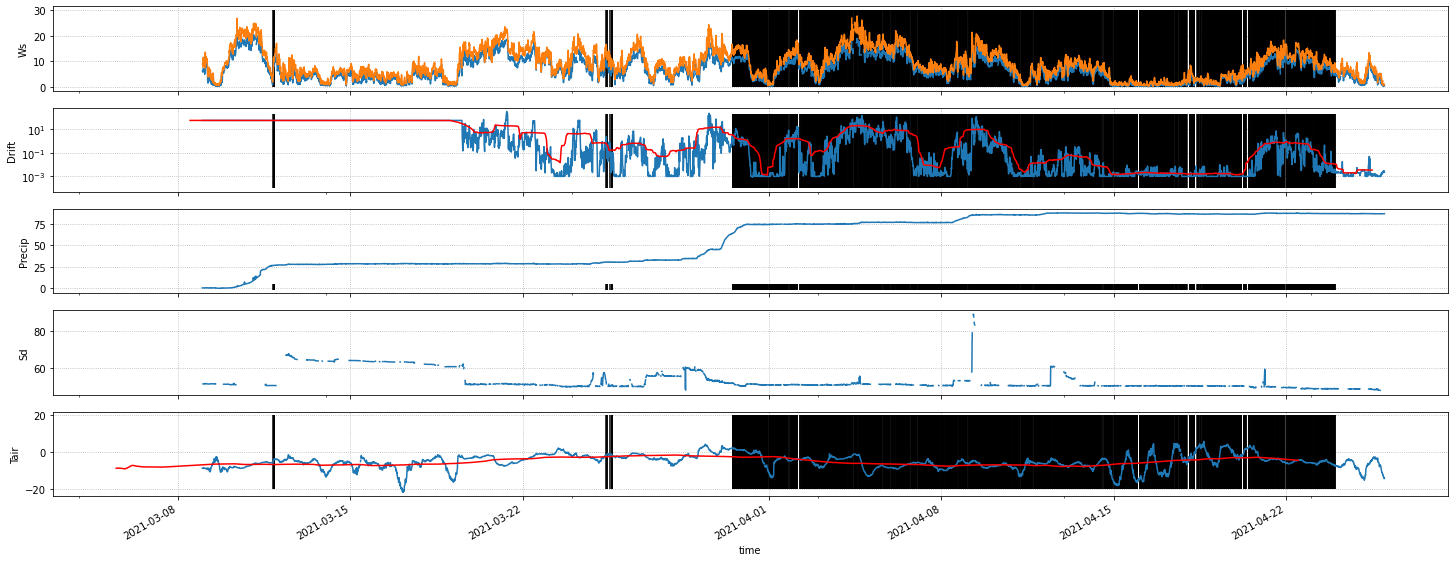

In [10]:
fig, ax = plt.subplots(5,1,sharex=True, figsize=(25,10))

# wind speed panel
df_mean_sub.ws.plot(ax=ax[0], label='Mean')
df_max_sub.ws.plot(ax=ax[0], label='Max')
ax[0].vlines(ds.time, 0, 30, color='k')
ax[0].set_ylabel('Ws')


# flowcapt panel
#(df_mean.fc1drift_mean).plot(ax=ax[1])
ax[1].semilogy(df_mean_sub.fc1drift_mean)
ax[1].semilogy(df_mean_sub.fc1drift_mean.rolling('1D').mean().shift(-12, freq='h'), color='r')
ax[1].vlines(ds.time, 0.0001, 200, color='k')

ax[1].set_ylabel('Drift')


# Precipitation panel
df_max_sub.precip.cumsum().plot(ax=ax[2])
ax[2].set_ylabel('Precip')
ax[2].vlines(ds.time, -2,4,color='k')

# Snow depth according to Snowdepth sensor
df_max_sub.metno_s.plot(ax=ax[3])
ax[3].set_ylabel('Sd')

# Temperature 
df_mean_sub.ta.plot(ax=ax[4])
df_mean_sub.ta.rolling('7D').mean().shift(-3.5, freq='D').plot(ax=ax[4], color='r', label='Weekly mean')
ax[4].vlines(ds.time, -20, 20, color='k')

ax[4].set_ylabel('Tair')

[x.grid(linestyle=':') for x in ax]
plt.show()

## 3. Extract Weather data in respect to scan timestamp
- extract instantaneous values: Ta, ws, wd, 
- values during scanning intervals:
    - mean: Tair, ws, wd
    - cumulative: precip, drift 

In [11]:
df_mean.loc[ds.time]

,time,fc1drift_mean,fc2drift_mean,wd,ws,ta,metno_r,metno_s,precip,U,V
time,,,,,,,,,,,
2021-03-11 21:12:00,1615497120,53.247000,6.089,253.194444,6.444583,-4.581293,468.501597,50.32,0.031001,-0.748099,6.401016
2021-03-11 21:24:00,1615497840,53.247000,6.089,291.125000,8.703333,-3.833454,468.503275,50.32,0.001678,4.516944,7.439438
2021-03-11 21:36:00,1615498560,53.247000,6.089,297.111111,8.638472,-4.027890,468.512215,50.32,0.008940,5.228892,6.876183
2021-03-11 21:48:00,1615499280,53.247000,6.089,291.805556,9.052639,-3.691548,468.517824,50.32,0.005608,4.789808,7.681667
2021-03-11 22:00:00,1615500000,53.247000,6.089,299.375000,8.235694,-3.513808,468.524528,50.32,0.006704,5.240157,6.353535
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-23 22:36:00,1619217360,0.002000,71.298,314.763889,4.493889,-6.685727,257.783337,NaN,-0.002767,3.676828,2.583790
2021-04-23 22:48:00,1619218080,0.002000,71.298,299.180556,4.596250,-7.222654,257.773987,NaN,-0.009350,2.912424,3.555742
2021-04-23 23:00:00,1619218800,0.002264,71.298,294.083333,5.288472,-7.245491,257.778947,NaN,0.004960,2.974308,4.372806


In [12]:
# groupby daterange in between 2 scans
inter = pd.IntervalIndex.from_arrays(left=ds.time[:-1], right=ds.time[1:])


cut = pd.cut(df_mean.index, bins=inter)
grpd = df_mean.groupby(cut)

ds['ta_mean'] = grpd.fc1drift_mean.mean()
ds['U_mean'] = grpd.U.mean()
ds['V_mean'] = grpd.V.mean()
ds['ws_mean'] = grpd.ws.mean()
ds['wd_mean'] = np.mod(270 - (np.arctan2(ds.V_mean,ds.U_mean) * 180/np.pi), 360)
ds['drift_sum'] = grpd.fc1drift_mean.sum()
ds['precip_sum'] = grpd.precip.sum()
ds['metno_s'] = grpd.metno_s.last()

In [13]:
ds.to_pickle('data/scan_meteo.pckl')

Text(0.5, 0, '10m Mean Wind Speed [m.s$^{-1}$]')

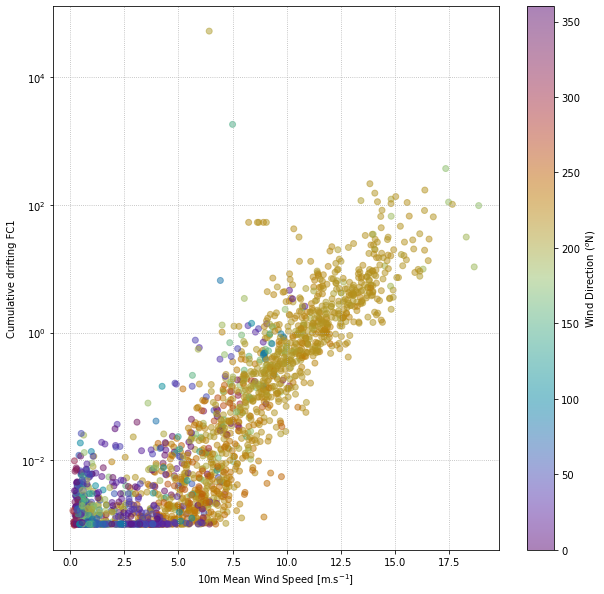

In [14]:
import cmasher as cmr

plt.figure(figsize=(10,10))
plt.scatter(ds.ws_mean, ds.drift_sum, c=ds.wd_mean, alpha=.5, cmap=cmr.infinity)
plt.clim(0,360)  # set colorscale to 360 deg range
plt.yscale('log')
cb = plt.colorbar()
cb.set_label('Wind Direction ($^{o}$N)')
plt.grid(linestyle=':')
plt.ylabel('Cumulative drifting FC1')
plt.xlabel('10m Mean Wind Speed [m.s$^{-1}$]')

## 4. 

In [42]:
pwd

'/home/simonfi/github/SnowyOwl/analysis'